In [1]:
import os, sys, json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sys.path.append("..")

In [2]:
# read from json
data = None
figure_name_prefix = "../figures/"
figure_name_suffix = "fig12b"

data_path = "../../../output/prioplus-eurosys25/experiments/" + figure_name_suffix + "/"
experiment_names = [
    "harvest-delay-rtt-newconfig-ackhigh-error",
    "swift-physics-priority-target",
    "swift-samedelay",
    "d2tcp-linestart",
    "harvest-ledbat",
    "ledbat",
    "swift-noprio"
]
experiment_suffix = ""

In [ ]:
# slowdowns = [[] for i in range(len(experiment_names))]
# avg_slowdowns = [[] for i in range(len(experiment_names))]
# p99_slowdowns = [[] for i in range(len(experiment_names))]
cfcts = [[] for i in range(len(experiment_names))]
avg_cfcts = [[] for i in range(len(experiment_names))]
p99_cfcts = [[] for i in range(len(experiment_names))]
# group the coflows, the list contain: total cct, first 4 prio cct, last 4 prio cct
avg_cfcts_group = [[] for i in range(len(experiment_names))]
p99_cfcts_group = [[] for i in range(len(experiment_names))]

for exp_idx, experiment_name in enumerate(experiment_names):
    with open(data_path + experiment_name + experiment_suffix + ".json", "r") as f:
        data = json.load(f)

    # group data:"flowStatistics":[:] by data:"flowStatistics":"flowType"
    # we have eight flow type, from 0 prio to 7 prio
    flow_types = [str(i) + "prio" for i in range(8)]
    flows = [[] for i in range(len(flow_types))]
    for flow in data["flowStatistics"]:
        # find the index of src_addr
        flow_type = flow["flowType"]
        index = flow_types.index(flow_type)
        flows[index].append(flow)

    # calculate the fct slowdown according to the data:"flowStatistics":[:]:"totalSizeBytes"
    flow_cfct = [{} for i in range(len(flow_types))]
    rtt = 12e3
    for i in range(len(flow_types)):
        for flow in flows[i]:
            total_size_bytes = flow["totalSizeBytes"]
            fct = flow["fctNs"]
            if flow["flowTag"] == "":
                continue
            flow_tag = flow["flowTag"].split(" ")[1]

            # slowdown = fct / (total_size_bytes * 8 / 100e9 * 1e9 + rtt)
            # flow_slowdown[i].append(slowdown)
            if flow_cfct[i].get(flow_tag) is None:
                flow_cfct[i][flow_tag] = fct
            else:
                flow_cfct[i][flow_tag] = max(flow_cfct[i][flow_tag], fct)

    # calculate the average slowdown and the p99 slowdowns
    avg_cfct = []
    p99_cfct = []
    avg_cfct_group = []
    p99_cfct_group = []
    for i in range(len(flow_types)):
        avg_cfct.append(np.mean(list(flow_cfct[i].values())))
        p99_cfct.append(np.percentile(list(flow_cfct[i].values()), 99))
    
    # mean of all flow types
    all_cfcts = [list(flow_cfct[i].values()) for i in range(len(flow_types))]
    all_cfcts = [item for sublist in all_cfcts for item in sublist]
    first4_cfcts = [list(flow_cfct[i].values()) for i in range(4)]
    first4_cfcts = [item for sublist in first4_cfcts for item in sublist]
    last4_cfcts = [list(flow_cfct[i].values()) for i in range(4, 8)]
    last4_cfcts = [item for sublist in last4_cfcts for item in sublist]
    
    # all_cfcts is a list of list, so we need to flatten it
    
    avg_cfct_group.append(np.mean(all_cfcts))
    # p99_cfct_group.append(np.percentile(all_cfcts, 99))
    avg_cfct_group.append(np.mean(first4_cfcts))
    # p99_cfct_group.append(np.percentile(first4_cfcts, 99))
    avg_cfct_group.append(np.mean(last4_cfcts))
    # p99_cfct_group.append(np.percentile(last4_cfcts, 99))

    #p99 不应该是all、first4、last4的累积p99，而是每个优先级的p99的平均
    p99_cfct_group.append(np.mean(p99_cfct))
    p99_cfct_group.append(np.mean(p99_cfct[:4]))
    p99_cfct_group.append(np.mean(p99_cfct[4:]))

    cfcts[exp_idx] = flow_cfct
    avg_cfcts[exp_idx] = avg_cfct
    p99_cfcts[exp_idx] = p99_cfct
    avg_cfcts_group[exp_idx] = avg_cfct_group
    p99_cfcts_group[exp_idx] = p99_cfct_group

In [ ]:
baseline_idx = 6

avg_cfcts_group_ratio = []
p99_cfcts_group_ratio = []
for i in range(len(avg_cfcts_group)):
    avg_cfcts_group_ratio.append(np.array(avg_cfcts_group[baseline_idx]) / np.array(avg_cfcts_group[i]))
    p99_cfcts_group_ratio.append(np.array(p99_cfcts_group[baseline_idx]) / np.array(p99_cfcts_group[i]))

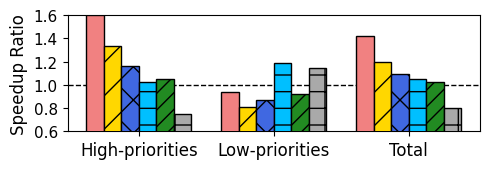

In [ ]:
hatches = ['', '/', 'x', '-', '//', '+']
colors = ['#f18181', '#ffd700', '#4068e1', '#00bfff', '#228b22', '#a9a9a9']

# plot the line figure of average slowdown and p99 slowdown in one figure
fig, ax1 = plt.subplots(1, figsize=(5, 1.8))

num_groups = 3
num_bars_per_group = 6
# width of each bar
bar_width = 0.13

group_positions = np.arange(num_groups)
bar_positions = [group_positions - (num_bars_per_group - 1) / 2 * bar_width + i * bar_width for i in range(num_bars_per_group)]

index = 0
exp_is = list(range(6))
labels = ["harvest-delay-direct", "swift-physics-priority-target", "swift-samedelay", "d2tcp-linestart", "harvest-ledbat", "LEDBAT"]
bar_idxs = [1,2,0]
for bar_idx, i in enumerate(exp_is):
    ax1.bar(bar_positions[index], [avg_cfcts_group_ratio[i][bar_idxs[tmp_i]] for tmp_i in range(3)],
            width=bar_width, linestyle='-', edgecolor='black', hatch=hatches[index], color=colors[index], label=experiment_names[i], zorder = 1111)
    index += 1

# ax.set_title("Average/P99 Slowdown")
# ax.set_xlabel("Flow Type")
ax1.set_ylabel("Speedup Ratio", fontsize=12)
# legend in two row
# ax[0].legend(ncol=2)
ax1.set_xticks(range(3))
xticklabels = ["High-priorities", "Low-priorities", "Total"]
ax1.set_xticklabels(xticklabels)
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=11)
yticks = [0.6,0.8,1.0,1.2,1.4,1.6]
ax1.set_yticks(yticks)

# ax.grid()
# ax[1].legend(ncol=2)
# log scale
# ax.set_yscale("log")
ax1.set_ylim(0.6,1.6)
ax1.axhline(y=1, color='black', linewidth=1, linestyle='--')

plt.tight_layout()

# save as pdf
plt.savefig(figure_name_prefix + "fig12b.pdf", bbox_inches='tight', dpi=600, format='pdf')


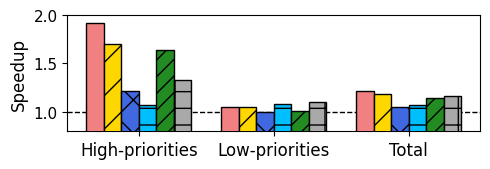

In [ ]:
hatches = ['', '/', 'x', '-', '//', '+']
colors = ['#f18181', '#ffd700', '#4068e1', '#00bfff', '#228b22', '#a9a9a9']

# plot the line figure of average slowdown and p99 slowdown in one figure
fig, ax1 = plt.subplots(1, figsize=(5, 1.8))

num_groups = 3
num_bars_per_group = 6
# width of each bar
bar_width = 0.13

group_positions = np.arange(num_groups)
bar_positions = [group_positions - (num_bars_per_group - 1) / 2 * bar_width + i * bar_width for i in range(num_bars_per_group)]

index = 0
exp_is = list(range(6))
labels = ["harvest-delay-direct", "swift-physics-priority-target", "swift-samedelay", "d2tcp-linestart", "harvest-ledbat", "LEDBAT"]
bar_idxs = [1,2,0]

#plot p99
for bar_idx, i in enumerate(exp_is):
    ax1.bar(bar_positions[index], [p99_cfcts_group_ratio[i][bar_idxs[tmp_i]] for tmp_i in range(3)],
            width=bar_width, linestyle='-', edgecolor='black', hatch=hatches[index], color=colors[index], label=experiment_names[i], zorder = 1111)
    index += 1  
ax1.set_ylabel("Speedup", fontsize=12)
# legend in two row
# ax[0].legend(ncol=2)
ax1.set_xticks(range(3))
xticklabels = ["High-priorities", "Low-priorities", "Total"]
ax1.set_xticklabels(xticklabels)
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=11)
ax1.set_ylim(0.8,2.0)
ax1.axhline(y=1, color='black', linewidth=1, linestyle='--')

plt.tight_layout()

# this figure is p99 placed in appendix
plt.show()